# Amazon Forecast: predicting time-series at scale

Forecasting is used in a variety of applications and business use cases: For example, retailers need to forecast the sales of their products to decide how much stock they need by location, Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, Businesses need to estimate their flexible workforce needs, Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and 
enterprises need to estimate their cloud infrastructure needs.

<img src="BlogImages/amazon_forecast.png">


# Table of Contents

* Step 0: [Setting up](#setup)
* Step 1: [Preparing the Datasets](#prepare)
* Step 2: [Importing the Data](#import)
 * Step 2a: [Creating a Dataset Group](#create)
 * Step 2b: [Creating a Target Dataset](#target)
 * Step 2c: [Creating a Item Metadata Dataset](#metadata)
 * Step 2d: [Update the Dataset Group](#update)
 * Step 2e: [Creating a Target Time Series Dataset Import Job](#targetImport)
 * Step 2f: [Creating a Item Metadata Dataset Import Job](#metadataImport)
* Step 3: [Choosing an Algorithm and Evaluating its Performance](#algo)
* Step 4: [Computing Error Metrics from Backtesting](#error)
* Step 5: [Creating a Forecast](#forecast)
* Step 6: [Querying the Forecasts](#query)
* Step 7: [Exporting the Forecasts](#export)
* Step 8: [Clearning up your Resources](#cleanup)


#  First let us setup Amazon Forecast<a class="anchor" id="setup">

This section sets up the permissions and relevant endpoints.

In [2]:
%load_ext autoreload
%autoreload 2
from util.fcst_utils import *
import warnings
import boto3
import s3fs
plt.rcParams['figure.figsize'] = (15.0, 5.0)
warnings.filterwarnings('ignore')

Although, we have set the region to us-west-2 below, you can choose any of the 6 regions that the service is available in.

In [3]:
region = 'us-west-2'
bucket = 'item-metadata-demo'
version = 'prod'

In [4]:
session = boto3.Session(region_name='us-west-2') 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [ ]:
role_arn = get_or_create_role_arn()

# Overview

<img src="BlogImages/outline.png">

<img src="BlogImages/forecast_workflow.png">

The above figure summarizes the key workflow of using Forecast. 

# Step 1: Preparing the Datasets<a class="anchor" id="prepare">

In [6]:
time_series_df = pd.read_csv("../data/item-demand-time.csv", dtype = object, names = ['timestamp', 'target_value', 'item'])
time_series_df.head(3)

,timestamp,target_value,item
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


In addition to the target timeseries dataset, we upload an item metadata dataset. Item metadata is any categorical feature that is applicable to the target timeseries data. For example, to forecast sales of 
a particular product, attributes of this product, such as brand, color, and genre are a part of item metadata.  Unlike related time series that depend on time, item metadata is fixed in time and each item has one associated item metadata value, e.g. the category or bin that it belongs to.  In the following example, we will use region as the item metadata.

In [7]:
item_metadata_df = pd.read_csv("../data/item-meta.csv", dtype = object, names = ['item', 'region'])
item_metadata_df.head(3)

,item,region
0,client_111,a
1,client_12,b
2,client_10,a


In order to use the item metadata dataset, we should make sure that the set of items that are present in the target timeseries is the same as the set of items that are present in the item metadata dataset. If an item has no relevant value for a particular attribute, the value `"N\A"` can be specified.

In addition, the number of items in each category should be large enough to produce a sufficient signal for the algorithm to use.  We advise against using sparse categories.  For example, if there are categories consisting of only 10% or fewer of the items, we recommend creating a new category labeled `"others"`, which combines all these categories with the small amount of items into one and removes those old category labels.

In [8]:
target_items = set(time_series_df["item"].tolist())
metadata_items = set(item_metadata_df["item"].tolist())
print(target_items)
print(metadata_items)
assert len(target_items - metadata_items) == 0, "items do not match"

{'client_12', 'client_111', 'client_10'}
{'client_12', 'client_111', 'client_10'}


As we can see, the set of items in the target dataset is the same as the set of items in the item metadata. We can go ahead and upload the datasets.

In [9]:
s3 = session.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')

If you don't have this bucket `amazon-forecast-data-{account_id}`, create it first on S3.

In [10]:
bucket_name = f"amazon-forecast-data-{account_id}"
key = "item_metadata_demo_small"

s3.upload_file(Filename="../data/item-demand-time.csv", Bucket = bucket_name, Key = f"{key}/target.csv")
s3.upload_file(Filename="../data/item-meta.csv", Bucket = bucket_name, Key = f"{key}/metadata.csv")

# Step 2. Importing the Data<a class="anchor" id="import">
Now we are ready to import the datasets into the Forecast service. Starting from the raw data, Amazon Forecast automatically extracts the dataset that is suitable for forecasting. As an example, a retailer normally records the transaction record such as
<img src="BlogImages/data_format.png">
<img src="BlogImages/import1.png">
<img src="BlogImages/import2.png">

In [16]:
project = "item_metadata_demo"
idx = 0 # so that we have a unique name

In [17]:
s3_data_path = f"s3://{bucket_name}/{key}"

Below, we specify key input data and forecast parameters

In [18]:
freq = "H"
forecast_horizon = 24
timestamp_format = "yyyy-MM-dd HH:mm:ss"
delimiter = ','

## Step 2a. Creating a Dataset Group<a class="anchor" id="create">
First let's create a dataset group and then update it later to add our datasets.

In [19]:
dataset_group = f"{project}_gp_{idx}"
dataset_arns = []
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=dataset_group,
                                                              DatasetArns=dataset_arns,
                                                              Domain="CUSTOM")

In [20]:
logging.info(f'Creating dataset group {dataset_group}')

In [21]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2b. Creating a Target Dataset<a class="anchor" id="target">
In this example, we will define a target time series. This is a required dataset to use the service.
    
Below we specify the target time series name:

In [23]:
ts_dataset_name = f"{project}_ts_{idx}"
print(ts_dataset_name)

item_metadata_demo_ts_0


Next, we specify the schema of our dataset below. Make sure the order of the attributes (columns) matches the raw data in the files. We follow the same three attribute format as the above example.

In [24]:
ts_schema_val = [{"AttributeName": "timestamp", "AttributeType": "timestamp"},
                {"AttributeName": "target_value", "AttributeType": "float"},
                {"AttributeName": "item_id", "AttributeType": "string"}]
ts_schema = {"Attributes": ts_schema_val}

In [25]:
logging.info(f'Creating target dataset {ts_dataset_name}')

In [26]:
response = forecast.create_dataset(Domain="CUSTOM",
                               DatasetType='TARGET_TIME_SERIES',
                               DatasetName=ts_dataset_name,
                               DataFrequency=freq,
                               Schema=ts_schema
                              )

In [27]:
ts_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

## Step 2c. Creating a Item Metadata Dataset<a class="anchor" id="metadata">
In this example, we will define a item metadata dataset.
    
Below we specify the item metadata name:



In [29]:
meta_dataset_name = f"{project}_meta_{idx}"
print(meta_dataset_name)

item_metadata_demo_meta_0


Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.

In [30]:
meta_schema_val = [{"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "region_id", "AttributeType": "string"}]
meta_schema = {"Attributes": meta_schema_val}

In [31]:
logging.info(f'Creating item_metadata dataset {meta_dataset_name}')

In [32]:
response = forecast.create_dataset(Domain="CUSTOM",
                               DatasetType='ITEM_METADATA',
                               DatasetName=meta_dataset_name,
                               Schema=meta_schema
                              )

In [33]:
meta_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn = meta_dataset_arn)

## Step 2d. Updating the dataset group with the datasets we created<a class="anchor" id="update">
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [ ]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(meta_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2e. Creating a Target Time Series Dataset Import Job<a class="anchor" id="targetImport">

In [37]:
ts_s3_data_path = f"{s3_data_path}/target.csv"

In [38]:
ts_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=ts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": ts_s3_data_path,
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

In [39]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

In [40]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

.......


## Step 2f. Creating a Item Metadata Dataset Import Job<a class="anchor" id="metadataImport">

In [41]:
meta_s3_data_path = f"{s3_data_path}/metadata.csv"

In [42]:
meta_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=meta_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": meta_s3_data_path,
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             })

In [43]:
meta_dataset_import_job_arn=meta_dataset_import_job_response['DatasetImportJobArn']

In [44]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=meta_dataset_import_job_arn))
assert status

....


# Step 3. Choosing an algorithm and evaluating its performance<a class="anchor" id="algo">

Once the datasets are specified with the corresponding schema, Amazon Forecast will automatically aggregate all the relevant pieces of information for each item, such as sales, price, promotions, as well as categorical attributes, and generate the desired dataset. Next, one can choose an algorithm (forecasting model) and evaluate how well this particular algorithm works on this dataset. The following graph gives a high-level overview of the forecasting models.
<img src="BlogImages/recipes.png">
<img src="BlogImages/pred_details.png">

Amazon Forecast provides several state-of-the-art forecasting algorithms including classic forecasting methods such as ETS, ARIMA, Prophet and deep learning approaches such as DeepAR+. Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit a single model to each individual time series, and then use that model to extrapolate the time series into the future. Amazon's Non-Parametric Time Series (NPTS) forecaster also fits a single model to each individual time series.  Unlike the naive or seasonal naive forecasters that use a fixed time index (the previous index $T-1$ or the past season $T - \tau$) as the prediction for time step $T$, NPTS randomly samples a time index $t \in \{0, \dots T-1\}$ in the past to generate a sample for the current time step $T$.

In many applications, you may encounter many similar time series across a set of cross-sectional units. Examples of such time series groupings are demand for different products, server loads, and requests for web pages. In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR+ takes this approach, outperforming the standard ARIMA and ETS methods when your dataset contains hundreds of related time series. The trained model can also be used for generating forecasts for new time series that are similar to the ones it has been trained on. While deep learning approaches can outperform standard methods, this is only possible when there is sufficient data available for training. It is not true for example when one trains a neural network with a time-series contains only a few dozens of observations. Amazon Forecast provides the best of two worlds allowing users to either choose a specific algorithm or let Amazon Forecast automatically perform model selection. 

## How to evaluate a forecasting model?

Before moving forward, let's first introduce the notion of *backtest* when evaluating forecasting models. The key difference between evaluating forecasting algorithms and standard ML applications is that we need to make sure there is no future information gets used in the past. In other words, the procedure needs to be causal. 

<img src="BlogImages/backtest.png">


In this notebook, we will use the neural network based method, DeepAR+, which is the only algorithm in Amazon Forecast that supports categorical features.


In [45]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'

In [46]:
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f'{project}_{algorithm.lower()}_{idx}'

In [47]:
logging.info(f'[{predictor_name_deep_ar}] Creating predictor {predictor_name_deep_ar} ...')

In [48]:
create_predictor_response = forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                                  ForecastHorizon=forecast_horizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                                  FeaturizationConfig= {"ForecastFrequency": freq}
                                                 )

In [49]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [50]:
status = wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
assert status

..........................................................


In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

# Step 4. Computing Error Metrics from Backtesting<a class="anchor" id="error">

After creating the predictors, we can query the forecast accuracy given by the backtest scenario and have a quantitative understanding of the performance of the algorithm. Such a process is iterative in nature during model development. When an algorithm with satisfying performance is found, the customer can deploy the predictor into a production environment, and query the forecasts for a particular item to make business decisions. 

In [52]:
logging.info('Done creating predictor. Getting accuracy numbers for DeepAR+ ...')

In [ ]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

In [54]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

The below figure shows a bar plot of various weighted quantile loss metrics (wQuantileLoss[$\tau$] for $\tau = 0.1, 0.5, 0.9$, corresponding to the `p10, p50, p90` quantile forecasts) of the predictor.

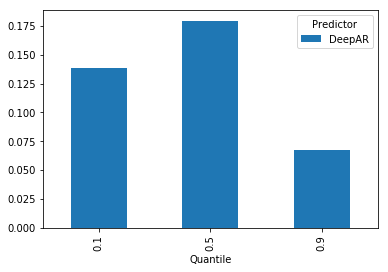

In [55]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar_plus, "DeepAR")
pd.concat([deep_ar_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar();

# Step 5. Creating a Forecast<a class="anchor" id="forecast">

Next we re-train with the full dataset, and create the forecast.

In [56]:
logging.info(f"Done fetching accuracy numbers. Creating forecaster for DeepAR+ ...")

In [57]:
forecast_name_deep_ar = f'{project}_deep_ar_plus_{idx}'

In [58]:
create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                        PredictorArn=predictor_arn_deep_ar)

In [59]:
forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [60]:
status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar))
assert status

..........................................................


In [ ]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

# Step 6. Querying the Forecasts<a class="anchor" id="query">

In [62]:
item_id = 'client_12'

In [63]:
forecast_response_deep = forecast_query.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": item_id})

In [64]:
fname = f'../data/item-demand-time.csv'
exact = load_exact_sol(fname, item_id, True)

The below figure shows a sample plot of different quantile forecasts (`p10, p50, p90`) of the predictor.  The `p50` quantile forecast is shown as the solid black line with the purple region denoting the confidence itnerval from the `p10` to the `p90` quantile forecasts.  The vertical green dashed lines denote the prediction interval.

Text(0.5, 1.0, 'DeepAR Forecast')

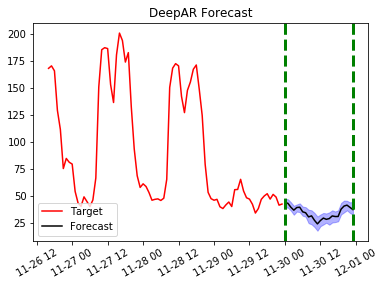

In [65]:
plot_forecasts(forecast_response_deep, exact)
plt.title("DeepAR Forecast")

# Step 7. Exporting your Forecasts<a class="anchor" id="export">

In [66]:
forecast_export_name_deep_ar = f'{project}_forecast_export_deep_ar_plus_{idx}'
forecast_export_name_deep_ar_path = f"{s3_data_path}/{forecast_export_name_deep_ar}"

In [67]:
create_forecast_export_response_deep_ar = forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_deep_ar,
                                                        ForecastArn=forecast_arn_deep_ar,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": forecast_export_name_deep_ar_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })
forecast_export_arn_deep_ar = create_forecast_export_response_deep_ar['ForecastExportJobArn']

In [ ]:
forecast.describe_forecast_export_job(ForecastExportJobArn=forecast_export_arn_deep_ar)

# Step 8. Cleaning up your Resources<a class="anchor" id="cleanup">

Once we have completed the above steps, we can start to cleanup the resources we created from the bottom up. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits are documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>. 

In [ ]:
# Delete forecast export
wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_deep_ar))

In [70]:
# Delete forecast
wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_deep_ar))

In [71]:
# Delete predictor
wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_deep_ar))

In [72]:
# Delete the target time series and item_metadata dataset import jobs
wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=meta_dataset_import_job_arn))

In [73]:
# Delete the target time series and item_metadata datasets
wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_dataset_arn))
wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=meta_dataset_arn))

In [ ]:
# Delete dataset group
forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn)